In [1]:
# #hide

%pip install pandas
%pip install numpy
%pip install scikit-learn==1.5.2
%pip install catboost
%pip install hyperopt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd #type: ignore
import numpy as np #type: ignore

In [3]:
df_classification = pd.read_csv("./train_taxi.csv")

In [4]:
df_classification.head()

,ID,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,...,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,trip_type,congestion_surcharge,payment_type
0,T03315,2.0,2021-07-02 17:19:11,2021-07-02 17:40:02,N,1.0,152,142,1.0,4.30,...,1.0,0.5,5.00,0.00,NaN,0.3,27.55,1.0,2.75,1.0
1,T07720,2.0,2021-07-05 22:48:04,2021-07-05 23:12:02,N,1.0,93,107,2.0,13.52,...,0.5,0.5,12.15,6.55,NaN,0.3,60.75,1.0,2.75,1.0
2,T09695,2.0,2021-07-07 06:29:43,2021-07-07 06:38:42,N,1.0,74,75,1.0,1.55,...,0.0,0.5,0.00,0.00,NaN,0.3,8.80,1.0,0.00,2.0
3,T08802,2.0,2021-07-06 15:33:29,2021-07-06 15:43:25,N,1.0,226,129,1.0,1.22,...,0.0,0.5,0.00,0.00,NaN,0.3,8.80,1.0,0.00,2.0
4,T01413,2.0,2021-07-01 17:09:07,2021-07-01 18:03:12,N,1.0,55,86,1.0,14.23,...,1.0,0.5,0.00,2.45,NaN,0.3,49.75,1.0,0.00,1.0


In [5]:
df_classification = df_classification.drop(columns=['ehail_fee'])

In [6]:
df_classification = df_classification[df_classification['payment_type'].isin([1,2])]

In [7]:
df_classification =df_classification.drop(columns=['ID'])

In [8]:
df_classification = df_classification.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1)

In [9]:
df_classification['payment_type'] = df_classification['payment_type'].replace({
    2: 0,
    1: 1
})

In [10]:
df_classification['is_give_tip_using_credit_card'] = np.where(df_classification['tip_amount'] > 0, 1, 0)

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_classification["store_and_fwd_flag"] = label_encoder.fit_transform(df_classification["store_and_fwd_flag"])

In [12]:
df_classification['trip_type'] = df_classification['trip_type'].astype('int')
df_classification["RatecodeID"] = df_classification["RatecodeID"].astype('int')
df_classification["passenger_count"]  = df_classification["passenger_count"].astype('int')
df_classification["VendorID"] = df_classification["VendorID"].astype('int')

In [13]:
df_classification.apply(lambda x: x.unique())

VendorID                                                                    [2, 1]
store_and_fwd_flag                                                          [0, 1]
RatecodeID                                                         [1, 5, 2, 4, 3]
PULocationID                     [152, 93, 74, 226, 55, 75, 212, 82, 244, 41, 6...
DOLocationID                     [142, 107, 75, 129, 86, 263, 212, 226, 235, 74...
passenger_count                                              [1, 2, 3, 6, 5, 4, 0]
trip_distance                    [4.3, 13.52, 1.55, 1.22, 14.23, 1.2, 0.0, 2.34...
fare_amount                      [18.0, 38.0, 8.0, 45.5, 7.2, 25.0, 10.5, 7.0, ...
extra                                       [1.0, 0.5, 0.0, 3.75, 2.75, 3.25, 4.5]
mta_tax                                                                 [0.5, 0.0]
tip_amount                       [5.0, 12.15, 0.0, 1.0, 3.6, 2.51, 7.41, 6.11, ...
tolls_amount                     [0.0, 6.55, 2.45, 6.12, 3.0, 13.75, 9.0, 13.1,...
impr

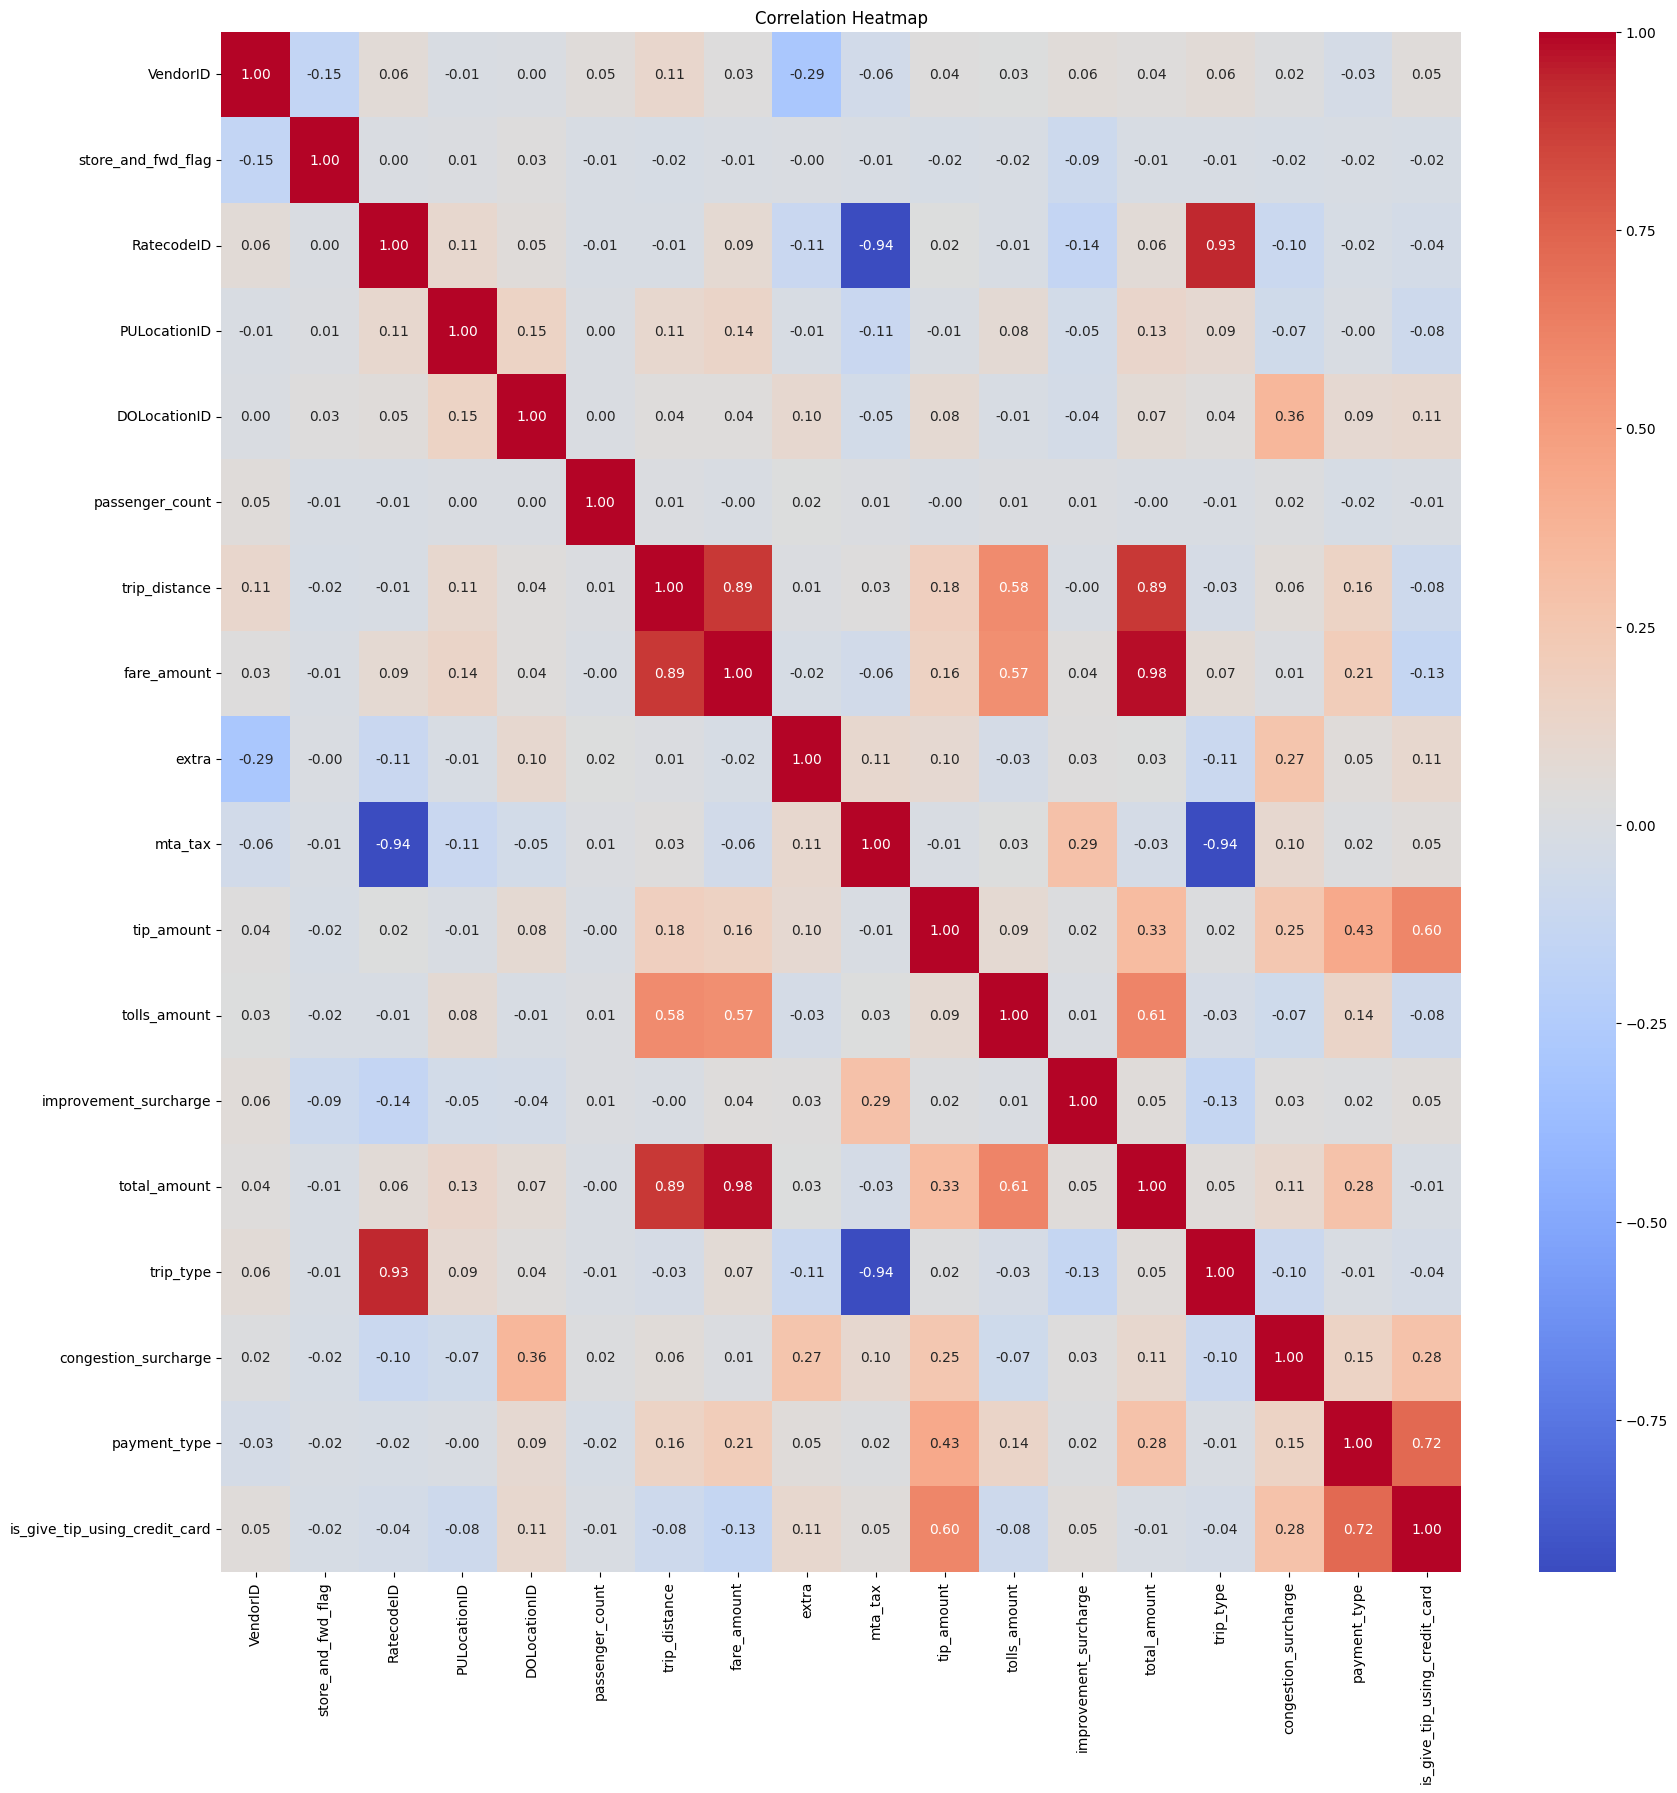

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_classification.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [15]:
from catboost import CatBoostClassifier, Pool, metrics, cv # type: ignore
from sklearn.model_selection import train_test_split #type: ignore

numeric_features = [
    'trip_distance',
    'fare_amount',
    'extra',
    'tip_amount',
    'tolls_amount',
    'total_amount',
    'congestion_surcharge',
    'improvement_surcharge',
    'mta_tax'
]

categorical_features = df_classification.columns.difference(numeric_features)

X = df_classification.drop(columns='payment_type')
y = df_classification['payment_type']

print(categorical_features)

Index(['DOLocationID', 'PULocationID', 'RatecodeID', 'VendorID',
       'is_give_tip_using_credit_card', 'passenger_count', 'payment_type',
       'store_and_fwd_flag', 'trip_type'],
      dtype='object')


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_feature_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=categorical_feature_indices
)

In [17]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        use_best_model=True,
        loss_function=metrics.Logloss(),
        random_seed=42,
        depth=8,
        boosting_type='Ordered',
        eval_metric=metrics.F1(),
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_feature_indices),
        model.get_params(),
        logging_level="Silent",
    )
    best_accuracy = np.max(cv_data['test-F1-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [18]:
from numpy.random import default_rng

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=default_rng(123)
)

print(best)

100%|██████████| 50/50 [25:12<00:00, 30.25s/trial, best loss: 0.0640007339760017] 
{'l2_leaf_reg': 3.0, 'learning_rate': 0.11424843455015068}


In [19]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=1000,
    use_best_model=True,
    loss_function=metrics.Logloss(),
    random_seed=42,
    depth=8,
    verbose=1,
    boosting_type='Ordered',
    eval_metric=metrics.F1(),
)

In [20]:
model.fit(train_pool, eval_set=test_pool, verbose=True)

0:	learn: 0.8982883	test: 0.9001793	best: 0.9001793 (0)	total: 26.9ms	remaining: 26.8s
1:	learn: 0.9232459	test: 0.9243306	best: 0.9243306 (1)	total: 52.9ms	remaining: 26.4s
2:	learn: 0.9233738	test: 0.9220023	best: 0.9243306 (1)	total: 68.6ms	remaining: 22.8s
3:	learn: 0.9236970	test: 0.9259694	best: 0.9259694 (3)	total: 85.6ms	remaining: 21.3s
4:	learn: 0.9277809	test: 0.9253209	best: 0.9259694 (3)	total: 98.5ms	remaining: 19.6s
5:	learn: 0.9296712	test: 0.9263158	best: 0.9263158 (5)	total: 112ms	remaining: 18.5s
6:	learn: 0.9299681	test: 0.9263158	best: 0.9263158 (5)	total: 125ms	remaining: 17.7s
7:	learn: 0.9299487	test: 0.9268578	best: 0.9268578 (7)	total: 138ms	remaining: 17.1s
8:	learn: 0.9304650	test: 0.9268578	best: 0.9268578 (7)	total: 153ms	remaining: 16.8s
9:	learn: 0.9300583	test: 0.9268578	best: 0.9268578 (7)	total: 160ms	remaining: 15.8s
10:	learn: 0.9305556	test: 0.9268578	best: 0.9268578 (7)	total: 173ms	remaining: 15.5s
11:	learn: 0.9307041	test: 0.9284877	best: 0.928

In [21]:
y_pred = model.predict(test_pool)

In [22]:
from sklearn.metrics import f1_score #type: ignore

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1:.4f}')

F1 score: 0.9366


In [23]:
df_test_classification = pd.read_csv("./taxi_trip_classif.csv")

In [24]:
df_test_classification = df_test_classification.drop(columns=['ehail_fee'], axis=1)

In [25]:
processed_df_test_classification = df_test_classification.copy()
processed_df_test_classification = processed_df_test_classification.drop(columns='ID', axis=1)

In [26]:
processed_df_test_classification = processed_df_test_classification.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1)

In [27]:
processed_df_test_classification['is_give_tip_using_credit_card'] = np.where(processed_df_test_classification['tip_amount'] > 0, 1, 0)

In [28]:
processed_df_test_classification["store_and_fwd_flag"] = label_encoder.transform(processed_df_test_classification["store_and_fwd_flag"])

In [29]:
processed_df_test_classification['trip_type'] = processed_df_test_classification['trip_type'].astype('int')
processed_df_test_classification["RatecodeID"] = processed_df_test_classification["RatecodeID"].astype('int')
processed_df_test_classification["passenger_count"]  = processed_df_test_classification["passenger_count"].astype('int')
processed_df_test_classification["VendorID"] = processed_df_test_classification["VendorID"].astype('int')

In [30]:
processed_df_test_classification.apply(lambda x: x.unique())

VendorID                                                                    [2, 1]
store_and_fwd_flag                                                          [0, 1]
RatecodeID                                                         [1, 5, 4, 2, 3]
PULocationID                     [129, 41, 227, 130, 166, 241, 18, 33, 74, 95, ...
DOLocationID                     [28, 142, 181, 205, 166, 127, 197, 40, 130, 23...
passenger_count                                              [1, 2, 6, 5, 0, 3, 4]
trip_distance                    [8.49, 2.67, 0.0, 2.8, 1.75, 2.56, 17.83, 1.01...
fare_amount                      [29.5, 12.5, 10.2, 13.0, 8.0, 14.5, 60.0, 5.5,...
extra                            [0.5, 0.0, 1.0, 2.75, 3.75, 4.5, 3.25, -1.0, -...
mta_tax                                                           [0.5, 0.0, -0.5]
tip_amount                       [0.0, 1.0, 3.45, 3.0, 2.36, 2.0, 2.71, 9.72, 2...
tolls_amount                             [0.0, 6.55, 3.0, 2.45, 13.1, 11.75, 6.12]
impr

In [31]:
y_result = model.predict(processed_df_test_classification)

In [32]:
csv_result = pd.DataFrame({
    "ID": df_test_classification["ID"],
    "payment_type": y_result
})

csv_result["payment_type"] = csv_result["payment_type"].replace({
    0: 2,
    1: 1
})

In [33]:
csv_result

,ID,payment_type
0,T05226,2.0
1,T02377,1.0
2,T08294,1.0
3,T00815,1.0
4,T04025,1.0
...,...,...
1595,T07378,1.0
1596,T01681,1.0
1597,T03778,2.0
1598,T08415,2.0


In [34]:
from datetime import datetime
from zoneinfo import ZoneInfo

utc_plus_7 = ZoneInfo("Asia/Bangkok")
current_iso_timestamp = datetime.now(utc_plus_7).isoformat()

filename = f"submission_kasdead_klasifikasi_catboost_{current_iso_timestamp}.csv"
csv_result.to_csv(filename, index=False)